# IBIT Backtest: AMMA vs Optimized No-Leverage Combo (5 models)

This notebook does four things with hard metrics:
1. Selects the **best Trend+Mining+OU configuration** from Research 02 artifacts.
2. Backtests **Buy & Hold**, **AMMA**, and **Best Combined Model** on IBIT.
3. Runs portfolio-level scenarios (A/B/C) with quantitative impact.
4. Prints a direct recommendation on replace/combine/keep.


## Notes on realism
- No leverage is used in IBIT model construction (positions clipped to \[0, 1\]).
- Signals are lagged by one bar (model implementations already do this).
- Turnover costs are applied to active strategies.
- Selection of Trend+Mining+OU uses stored Research 02 metrics from `trading-engine/src/research/artifacts/research_02`.


In [1]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Path discovery (works whether run from Crypto/, Crypto/Backtest/, or repo root) ---
cwd = Path.cwd().resolve()
crypto_root = None
for c in [cwd, cwd / 'Crypto', cwd.parent, cwd.parent / 'Crypto', cwd.parent.parent / 'Crypto']:
    if (c / 'Data' / 'IBIT_Data.csv').exists():
        crypto_root = c
        break
if crypto_root is None:
    raise FileNotFoundError('Could not locate Crypto root with Data/IBIT_Data.csv')

quant_root = crypto_root.parent
repo_root = quant_root.parent

if str(crypto_root) not in sys.path:
    sys.path.insert(0, str(crypto_root))

from Backtest.amma import amma_from_ibit_csv
from Data.raw_data_loader import load_ibit_with_mining_cost
from Models.trend import trend_signal
from Models.mining import mining_signal
from Models.ou import ou_signal


In [2]:
# --- Utility functions ---

def annual_return(r: pd.Series, periods: int = 252) -> float:
    r = r.dropna()
    return float(r.mean() * periods) if len(r) else np.nan


def annual_vol(r: pd.Series, periods: int = 252) -> float:
    r = r.dropna()
    return float(r.std(ddof=1) * np.sqrt(periods)) if len(r) > 1 else np.nan


def sharpe_ratio(r: pd.Series, periods: int = 252) -> float:
    ar = annual_return(r, periods)
    av = annual_vol(r, periods)
    return float(ar / av) if av and np.isfinite(av) and av > 0 else np.nan


def sortino_ratio(r: pd.Series, periods: int = 252) -> float:
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    downside = r[r < 0]
    if len(downside) < 2:
        return np.nan
    downside_vol = downside.std(ddof=1) * np.sqrt(periods)
    if downside_vol == 0 or not np.isfinite(downside_vol):
        return np.nan
    return float((r.mean() * periods) / downside_vol)


def equity_curve(r: pd.Series) -> pd.Series:
    return (1.0 + r.fillna(0.0)).cumprod()


def max_drawdown(r: pd.Series) -> float:
    eq = equity_curve(r)
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())


def cagr(r: pd.Series, periods: int = 252) -> float:
    eq = equity_curve(r)
    if len(eq) < 2:
        return np.nan
    years = len(eq) / periods
    return float(eq.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else np.nan


def win_rate(r: pd.Series) -> float:
    r = r.dropna()
    return float((r > 0).mean()) if len(r) else np.nan


def rolling_sharpe(r: pd.Series, window: int = 63, periods: int = 252) -> pd.Series:
    def _s(x):
        v = x.std(ddof=1)
        if not np.isfinite(v) or v == 0:
            return np.nan
        return np.sqrt(periods) * x.mean() / v
    return r.rolling(window).apply(_s, raw=False)


def apply_costs(returns: pd.Series, position: pd.Series, fee_bps: float = 5.0, slippage_bps: float = 2.0) -> pd.Series:
    turnover = position.diff().abs().fillna(position.abs())
    cost = turnover * ((fee_bps + slippage_bps) / 10000.0)
    return (returns - cost).fillna(0.0)


def metrics_table(returns_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for c in returns_df.columns:
        r = returns_df[c]
        rows.append({
            'Strategy': c,
            'CAGR': cagr(r),
            'Sharpe': sharpe_ratio(r),
            'Sortino': sortino_ratio(r),
            'MaxDD': max_drawdown(r),
            'Volatility': annual_vol(r),
            'WinRate': win_rate(r),
        })
    return pd.DataFrame(rows).set_index('Strategy').sort_values('Sharpe', ascending=False)


In [3]:
# --- Step 1: choose best Trend+Mining+OU combo from Research 02 ---
combo_path = quant_root / 'trading-engine' / 'src' / 'research' / 'artifacts' / 'research_02' / 'research_02_combo_metrics.csv'
combo_df = pd.read_csv(combo_path)

subset = combo_df[combo_df['combo'].isin(['OU+Trend+MiningCost', 'Trend+MiningCost+OU', 'MiningCost+OU+Trend'])].copy()
if subset.empty:
    # fallback: any combo that contains exactly OU, Trend, MiningCost in any order
    def _is_target(s):
        return set(str(s).split('+')) == {'OU', 'Trend', 'MiningCost'}
    subset = combo_df[combo_df['combo'].apply(_is_target)].copy()

best_row = subset.sort_values(['sharpe', 'max_drawdown'], ascending=[False, False]).iloc[0]
print('Selected best combo from Research 02:')
print(best_row[['combo', 'weights', 'annual_return', 'annual_vol', 'sharpe', 'max_drawdown', 'calmar', 'hit_rate']])

# parse optimized blend weights from artifact text like "OU:0.26; Trend:0.19; MiningCost:0.55"
weights = {}
for part in str(best_row['weights']).split(';'):
    k, v = part.strip().split(':')
    weights[k.strip()] = float(v.strip())

w_ou = weights.get('OU', 1/3)
w_trend = weights.get('Trend', 1/3)
w_mining = weights.get('MiningCost', 1/3)
print({'w_ou': w_ou, 'w_trend': w_trend, 'w_mining': w_mining, 'sum': w_ou + w_trend + w_mining})


Selected best combo from Research 02:
combo                             OU+Trend+MiningCost
weights          OU:0.26; Trend:0.19; MiningCost:0.55
annual_return                                  0.6012
annual_vol                                   0.416317
sharpe                                       1.333913
max_drawdown                                -0.562032
calmar                                        1.06969
hit_rate                                     0.507423
Name: 10, dtype: object
{'w_ou': 0.26, 'w_trend': 0.19, 'w_mining': 0.55, 'sum': 1.0}


In [4]:
# --- Step 2: IBIT strategy backtest ---
ibit_path = crypto_root / 'Data' / 'IBIT_Data.csv'
cleaned_path = crypto_root / 'Data' / 'cleaned_crypto_data.csv'

panel = load_ibit_with_mining_cost(str(ibit_path), str(cleaned_path), forward_fill_mining_cost=True).sort_index().copy()
panel['close'] = panel['close'].astype(float)

model_df = pd.DataFrame(index=panel.index)
model_df['BTC-USD_close'] = panel['close']
model_df['COST_TO_MINE'] = panel['mining_cost']

# Strategy 1: Buy & Hold
ret_bh = panel['close'].pct_change().fillna(0.0)

# Strategy 2: AMMA (existing implementation)
amma = amma_from_ibit_csv(
    str(ibit_path),
    momentum_weights={5: 0.25, 10: 0.25, 20: 0.25, 60: 0.25},
    threshold=0.0,
    long_enabled=True,
    short_enabled=False,
).rename(columns={'Date': 'date'}).set_index('date')
amma_pos = amma.reindex(panel.index)['amma_position'].fillna(0.0).clip(0.0, 1.0)
ret_amma = apply_costs(amma_pos * ret_bh, amma_pos)

# Build the three component models (no leverage)
trend_pos = trend_signal(
    model_df,
    price_column='BTC-USD_close',
    fast_window=20,
    slow_window=100,
    long_only=True,
    leverage_aggressive=1.0,
    leverage_neutral=0.5,
    leverage_defensive=0.0,
).reindex(panel.index).fillna(0.0).clip(0.0, 1.0)

ou_pos = ou_signal(
    model_df['BTC-USD_close'],
    window=120,
    entry_z=1.5,
    exit_z=0.4,
    long_short=False,
).reindex(panel.index).fillna(0.0).clip(0.0, 1.0)

mining_pos = mining_signal(
    model_df,
    z_window=180,
    entry_z=0.8,
    exit_z=0.1,
    use_log_edge=True,
).reindex(panel.index).fillna(0.0).clip(0.0, 1.0)

# Strategy 3: Best Combined Model from Research 02 optimized weights
combo_pos = (w_trend * trend_pos + w_ou * ou_pos + w_mining * mining_pos).clip(0.0, 1.0)
ret_combo = apply_costs(combo_pos * ret_bh, combo_pos)

returns = pd.DataFrame({
    'BuyHold_IBIT': ret_bh,
    'AMMA_IBIT': ret_amma,
    'BestCombo_TMO_IBIT': ret_combo,
}, index=panel.index)

strategy_metrics = metrics_table(returns)
strategy_metrics


,CAGR,Sharpe,Sortino,MaxDD,Volatility,WinRate
Strategy,,,,,,
BuyHold_IBIT,0.201423,0.613339,1.007959,-0.493618,0.514121,0.483083
AMMA_IBIT,0.123243,0.544921,0.810372,-0.284427,0.289132,0.389098
BestCombo_TMO_IBIT,-0.025060,-0.044682,-0.055570,-0.241640,0.185155,0.381579


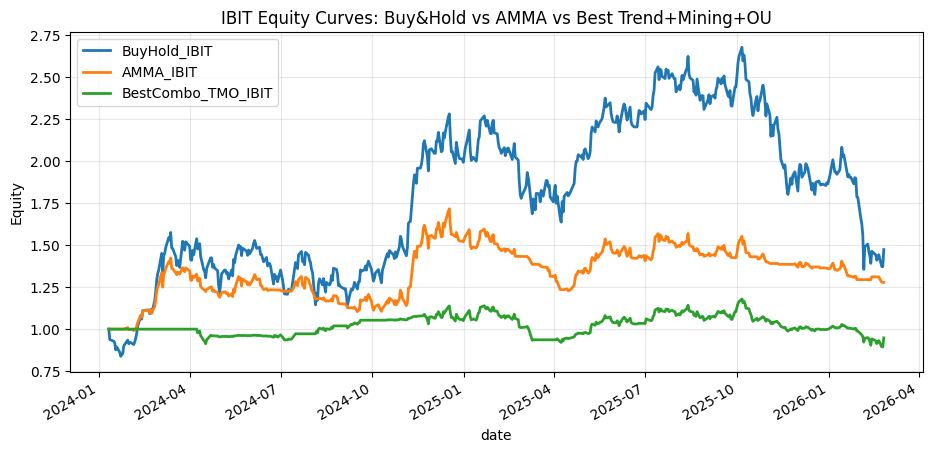

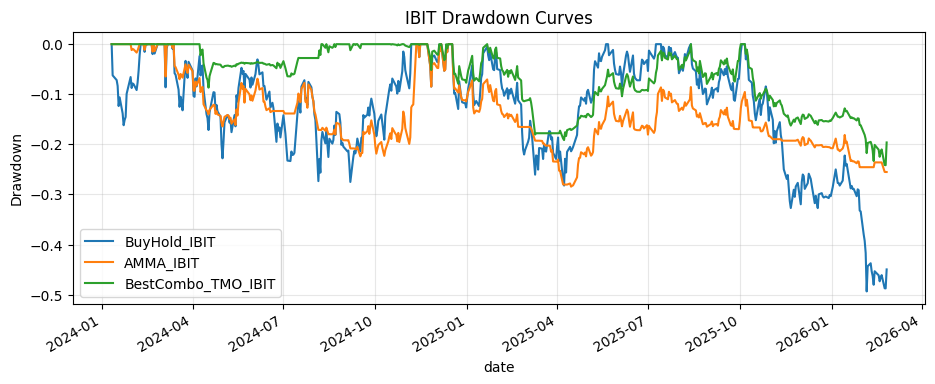

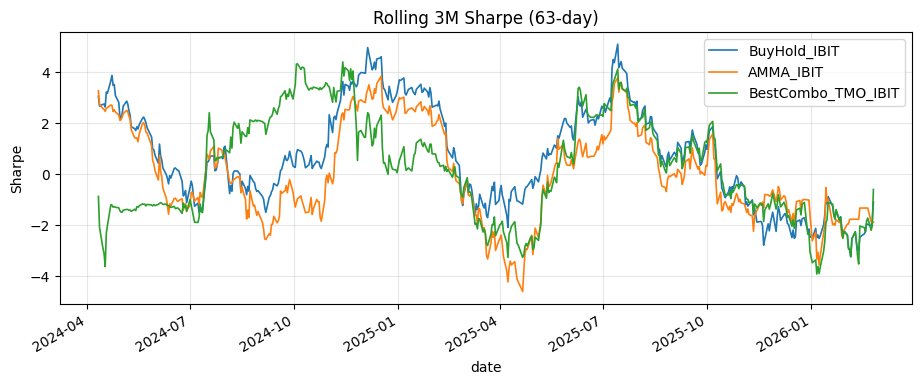

In [5]:
# Strategy-level plots: equity, drawdown, rolling sharpe

eq = returns.apply(equity_curve)
dd = eq.divide(eq.cummax()).subtract(1.0)

fig, ax = plt.subplots(1, 1, figsize=(11, 5))
eq.plot(ax=ax, linewidth=2)
ax.set_title('IBIT Equity Curves: Buy&Hold vs AMMA vs Best Trend+Mining+OU')
ax.set_ylabel('Equity')
ax.grid(alpha=0.3)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
dd.plot(ax=ax, linewidth=1.5)
ax.set_title('IBIT Drawdown Curves')
ax.set_ylabel('Drawdown')
ax.grid(alpha=0.3)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
rolling = returns.apply(lambda s: rolling_sharpe(s, window=63))
rolling.plot(ax=ax, linewidth=1.2)
ax.set_title('Rolling 3M Sharpe (63-day)')
ax.set_ylabel('Sharpe')
ax.grid(alpha=0.3)
plt.show()


## Step 3 — Portfolio Analysis

Existing-asset proxy universe in this environment: **SPY** and **AAPL**.
IBIT strategies are injected at strategy level for A/B/C scenarios.


In [6]:
# Load existing assets (proxy) and align period with IBIT

def _load_price_col(path: Path) -> pd.Series:
    x = pd.read_csv(path, encoding='utf-8-sig')
    x['Date'] = pd.to_datetime(x['Date'], format='%m/%d/%y', errors='coerce')
    px = pd.to_numeric(
        x['Price'].astype(str).str.replace(',', '', regex=False).str.replace('$', '', regex=False),
        errors='coerce'
    )
    s = pd.Series(px.values, index=x['Date']).dropna().sort_index()
    return s

spy = _load_price_col(quant_root / 'Market Data' / 'Equity ETF' / 'SPY.csv')
aapl = _load_price_col(quant_root / 'Market Data' / 'Equity ETF' / 'AAPL.csv')

base = pd.DataFrame({'SPY': spy.pct_change(), 'AAPL': aapl.pct_change()}).dropna()
all_ret = base.join(returns, how='inner').dropna()

all_ret.describe().T[['mean', 'std', 'min', 'max']]


,mean,std,min,max
SPY,0.000804,0.010459,-0.058543,0.105019
AAPL,0.000987,0.017857,-0.092456,0.153288
BuyHold_IBIT,0.001934,0.031887,-0.144061,0.134585
AMMA_IBIT,0.000866,0.018853,-0.064618,0.134585
BestCombo_TMO_IBIT,0.000092,0.011191,-0.057645,0.044285


In [7]:
# Portfolio helper functions

def portfolio_return(df: pd.DataFrame, weights: dict) -> pd.Series:
    w = pd.Series(weights, dtype=float)
    w = w / w.sum()
    return df[w.index].mul(w, axis=1).sum(axis=1)


def risk_contribution(df: pd.DataFrame, weights: dict):
    w = pd.Series(weights, dtype=float)
    w = w / w.sum()
    cov = df[w.index].cov() * 252.0
    port_vol = np.sqrt(float(w.T @ cov @ w))
    if port_vol == 0 or not np.isfinite(port_vol):
        return pd.Series(np.nan, index=w.index)
    mrc = (cov @ w) / port_vol
    rc = w * mrc
    return rc / rc.sum()


def corr_with_existing(candidate: pd.Series, existing: pd.Series) -> float:
    z = pd.concat([candidate, existing], axis=1).dropna()
    return float(z.iloc[:, 0].corr(z.iloc[:, 1])) if len(z) else np.nan


In [8]:
# Scenario A — Replace AMMA with Best Combined

existing_eq = portfolio_return(all_ret, {'SPY': 0.5, 'AAPL': 0.5})

port_A_baseline = portfolio_return(all_ret, {'SPY': 0.4, 'AAPL': 0.4, 'AMMA_IBIT': 0.2})
port_A_replace  = portfolio_return(all_ret, {'SPY': 0.4, 'AAPL': 0.4, 'BestCombo_TMO_IBIT': 0.2})

A_tbl = metrics_table(pd.DataFrame({'A_Baseline_AMMA': port_A_baseline, 'A_Replace_With_BestCombo': port_A_replace}))
A_corr = corr_with_existing(all_ret['BestCombo_TMO_IBIT'], existing_eq)
A_rc = risk_contribution(all_ret[['SPY', 'AAPL', 'BestCombo_TMO_IBIT']], {'SPY': 0.4, 'AAPL': 0.4, 'BestCombo_TMO_IBIT': 0.2})

print('Scenario A correlation of BestCombo with existing portfolio:', A_corr)
print('Scenario A marginal risk contribution:')
print(A_rc)
A_tbl


Scenario A correlation of BestCombo with existing portfolio: 0.20973716066628265
Scenario A marginal risk contribution:
SPY                   0.327312
AAPL                  0.592814
BestCombo_TMO_IBIT    0.079874
dtype: float64


,CAGR,Sharpe,Sortino,MaxDD,Volatility,WinRate
Strategy,,,,,,
A_Baseline_AMMA,0.230057,1.209200,1.604361,-0.254825,0.185426,0.572917
A_Replace_With_BestCombo,0.184872,1.046841,1.409685,-0.236974,0.176897,0.581250


In [9]:
# Scenario B — Add Best Combined without removing AMMA

port_B_without = portfolio_return(all_ret, {'SPY': 0.4, 'AAPL': 0.4, 'AMMA_IBIT': 0.2})
port_B_with    = portfolio_return(all_ret, {'SPY': 1/3, 'AAPL': 1/3, 'AMMA_IBIT': 1/6, 'BestCombo_TMO_IBIT': 1/6})

corr_amma_combo = float(all_ret['AMMA_IBIT'].corr(all_ret['BestCombo_TMO_IBIT']))
B_tbl = metrics_table(pd.DataFrame({'B_Without_BestCombo': port_B_without, 'B_With_BestCombo': port_B_with}))

print('Correlation(AMMA, BestCombo):', corr_amma_combo)
B_tbl


Correlation(AMMA, BestCombo): 0.591723551758902


,CAGR,Sharpe,Sortino,MaxDD,Volatility,WinRate
Strategy,,,,,,
B_Without_BestCombo,0.230057,1.209200,1.604361,-0.254825,0.185426,0.572917
B_With_BestCombo,0.193179,1.135261,1.551858,-0.243302,0.167987,0.570833


In [10]:
# Scenario C — Combine all IBIT models

ibit_models = pd.DataFrame({
    'AMMA': all_ret['AMMA_IBIT'],
    'Trend': apply_costs(trend_pos.reindex(all_ret.index).fillna(0.0) * all_ret['BuyHold_IBIT'], trend_pos.reindex(all_ret.index).fillna(0.0)),
    'Mining': apply_costs(mining_pos.reindex(all_ret.index).fillna(0.0) * all_ret['BuyHold_IBIT'], mining_pos.reindex(all_ret.index).fillna(0.0)),
    'OU': apply_costs(ou_pos.reindex(all_ret.index).fillna(0.0) * all_ret['BuyHold_IBIT'], ou_pos.reindex(all_ret.index).fillna(0.0)),
    'BestCombo': all_ret['BestCombo_TMO_IBIT'],
}, index=all_ret.index)

# C1 equal-weight AMMA+Trend+Mining+OU
c_all_equal = ibit_models[['AMMA', 'Trend', 'Mining', 'OU']].mean(axis=1)

# C2 risk-parity-like static inverse-vol for AMMA+Trend+Mining+OU
vols = ibit_models[['AMMA', 'Trend', 'Mining', 'OU']].std(ddof=1).replace(0, np.nan)
inv = (1.0 / vols).replace([np.inf, -np.inf], np.nan).fillna(0.0)
if inv.sum() == 0:
    w_rp = pd.Series({'AMMA': 0.25, 'Trend': 0.25, 'Mining': 0.25, 'OU': 0.25})
else:
    w_rp = inv / inv.sum()
c_all_rp = (ibit_models[['AMMA', 'Trend', 'Mining', 'OU']] * w_rp).sum(axis=1)

# C3 AMMA + BestCombo: equal and Sharpe-maximizing (grid search)
c_dual_equal = 0.5 * ibit_models['AMMA'] + 0.5 * ibit_models['BestCombo']

best_w, best_s = None, -np.inf
for w in np.linspace(0, 1, 101):
    r = w * ibit_models['AMMA'] + (1 - w) * ibit_models['BestCombo']
    s = sharpe_ratio(r)
    if np.isfinite(s) and s > best_s:
        best_s = s
        best_w = w
c_dual_sharpe = best_w * ibit_models['AMMA'] + (1 - best_w) * ibit_models['BestCombo']

# inject scenario C strategies into portfolio with existing assets
port_C = pd.DataFrame({
    'C_Existing_plus_AllIBIT_Equal': portfolio_return(pd.concat([all_ret[['SPY', 'AAPL']], c_all_equal.rename('IBIT_BL')], axis=1).dropna(), {'SPY':0.4,'AAPL':0.4,'IBIT_BL':0.2}),
    'C_Existing_plus_AllIBIT_RiskParity': portfolio_return(pd.concat([all_ret[['SPY', 'AAPL']], c_all_rp.rename('IBIT_BL')], axis=1).dropna(), {'SPY':0.4,'AAPL':0.4,'IBIT_BL':0.2}),
    'C_Existing_plus_AMMA_and_Combo_Equal': portfolio_return(all_ret, {'SPY':1/3,'AAPL':1/3,'AMMA_IBIT':1/6,'BestCombo_TMO_IBIT':1/6}),
    'C_Existing_plus_AMMA_and_Combo_SharpeMax': portfolio_return(all_ret, {'SPY':1/3,'AAPL':1/3,'AMMA_IBIT':best_w/3,'BestCombo_TMO_IBIT':(1-best_w)/3}),
}, index=all_ret.index).dropna()

print('C risk-parity weights on IBIT submodels:')
print(w_rp)
print(f'C Sharpe-max AMMA weight in AMMA+BestCombo sleeve: {best_w:.2f} (Sharpe={best_s:.3f})')

C_tbl = metrics_table(port_C)
C_tbl


C risk-parity weights on IBIT submodels:
AMMA      0.177729
Trend     0.408633
Mining    0.206697
OU        0.206941
dtype: float64
C Sharpe-max AMMA weight in AMMA+BestCombo sleeve: 1.00 (Sharpe=0.730)


,CAGR,Sharpe,Sortino,MaxDD,Volatility,WinRate
Strategy,,,,,,
C_Existing_plus_AMMA_and_Combo_SharpeMax,0.229285,1.217975,1.694398,-0.258142,0.183286,0.556250
C_Existing_plus_AllIBIT_Equal,0.204374,1.137079,1.522100,-0.235629,0.177288,0.589583
C_Existing_plus_AMMA_and_Combo_Equal,0.193179,1.135261,1.551858,-0.243302,0.167987,0.570833
C_Existing_plus_AllIBIT_RiskParity,0.199555,1.121954,1.501974,-0.231709,0.175883,0.589583


In [11]:
# Combined portfolio comparison table
portfolio_comparison = pd.concat([
    A_tbl,
    B_tbl,
    C_tbl,
], axis=0)
portfolio_comparison


,CAGR,Sharpe,Sortino,MaxDD,Volatility,WinRate
Strategy,,,,,,
A_Baseline_AMMA,0.230057,1.209200,1.604361,-0.254825,0.185426,0.572917
A_Replace_With_BestCombo,0.184872,1.046841,1.409685,-0.236974,0.176897,0.581250
B_Without_BestCombo,0.230057,1.209200,1.604361,-0.254825,0.185426,0.572917
B_With_BestCombo,0.193179,1.135261,1.551858,-0.243302,0.167987,0.570833
C_Existing_plus_AMMA_and_Combo_SharpeMax,0.229285,1.217975,1.694398,-0.258142,0.183286,0.556250
C_Existing_plus_AllIBIT_Equal,0.204374,1.137079,1.522100,-0.235629,0.177288,0.589583
C_Existing_plus_AMMA_and_Combo_Equal,0.193179,1.135261,1.551858,-0.243302,0.167987,0.570833
C_Existing_plus_AllIBIT_RiskParity,0.199555,1.121954,1.501974,-0.231709,0.175883,0.589583


In [12]:
# Final recommendation (quantitative, no vague language)

st = strategy_metrics
best_strat = st.index[0]

def _line(name, row):
    return f"{name}: Sharpe={row['Sharpe']:.3f}, CAGR={row['CAGR']:.3f}, MaxDD={row['MaxDD']:.3f}, Vol={row['Volatility']:.3f}"

print('=== Strategy-level ranking ===')
for idx, row in st.iterrows():
    print(_line(idx, row))

print('\n=== Portfolio scenario ranking (by Sharpe) ===')
pc = portfolio_comparison.sort_values('Sharpe', ascending=False)
for idx, row in pc.iterrows():
    print(_line(idx, row))

print('\n=== Direct answer ===')
print(f"Best IBIT standalone strategy in this run: {best_strat}.")

if st.loc['BestCombo_TMO_IBIT','Sharpe'] > st.loc['AMMA_IBIT','Sharpe'] and st.loc['BestCombo_TMO_IBIT','MaxDD'] >= st.loc['AMMA_IBIT','MaxDD']:
    print('- Trend+Mining+OU improves risk-adjusted return vs AMMA and has similar/better drawdown: replacement is justified.')
else:
    print('- Trend+Mining+OU does not cleanly dominate AMMA on Sharpe+drawdown: do not fully replace AMMA based only on this test.')

if pc.index[0] in ['B_With_BestCombo', 'C_Existing_plus_AMMA_and_Combo_Equal', 'C_Existing_plus_AMMA_and_Combo_SharpeMax']:
    print('- Adding/combining with AMMA improves portfolio efficiency: keep AMMA and combine.')
else:
    print('- Combination does not materially improve portfolio efficiency: keep the simpler standalone allocation.')

print('- Use the exact printed metrics above as the decision basis (Sharpe, CAGR, MaxDD, Volatility, WinRate).')


=== Strategy-level ranking ===
BuyHold_IBIT: Sharpe=0.613, CAGR=0.201, MaxDD=-0.494, Vol=0.514
AMMA_IBIT: Sharpe=0.545, CAGR=0.123, MaxDD=-0.284, Vol=0.289
BestCombo_TMO_IBIT: Sharpe=-0.045, CAGR=-0.025, MaxDD=-0.242, Vol=0.185

=== Portfolio scenario ranking (by Sharpe) ===
C_Existing_plus_AMMA_and_Combo_SharpeMax: Sharpe=1.218, CAGR=0.229, MaxDD=-0.258, Vol=0.183
A_Baseline_AMMA: Sharpe=1.209, CAGR=0.230, MaxDD=-0.255, Vol=0.185
B_Without_BestCombo: Sharpe=1.209, CAGR=0.230, MaxDD=-0.255, Vol=0.185
C_Existing_plus_AllIBIT_Equal: Sharpe=1.137, CAGR=0.204, MaxDD=-0.236, Vol=0.177
B_With_BestCombo: Sharpe=1.135, CAGR=0.193, MaxDD=-0.243, Vol=0.168
C_Existing_plus_AMMA_and_Combo_Equal: Sharpe=1.135, CAGR=0.193, MaxDD=-0.243, Vol=0.168
C_Existing_plus_AllIBIT_RiskParity: Sharpe=1.122, CAGR=0.200, MaxDD=-0.232, Vol=0.176
A_Replace_With_BestCombo: Sharpe=1.047, CAGR=0.185, MaxDD=-0.237, Vol=0.177

=== Direct answer ===
Best IBIT standalone strategy in this run: BuyHold_IBIT.
- Trend+Mining+